In [ ]:
!pip install datasets
!pip install -U accelerate
!pip install -U transformers
!pip install scikit-learn pillow torchvision opencv-python
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found

In [1]:
from datasets import load_dataset

# replace 'PranomVignesh/MRI-Images-of-Brain-Tumor' with the name of your dataset
dataset = load_dataset("PranomVignesh/MRI-Images-of-Brain-Tumor")

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict

In [ ]:
ds= dataset
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3759
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1073
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 537
    })
})

In [ ]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['glioma', 'meningioma', 'no-tumor', 'pituitary'], id=None)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def transform(example_batch):
    # Define the desired image size
    desired_size = (224, 224)

    # Resize the images to the desired size
    resized_images = [transforms.Resize(desired_size)(x.convert("RGB")) for x in example_batch['image']]

    # Convert resized images to pixel values
    inputs = processor(resized_images, return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']

    return inputs

prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3759
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1073
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 537
    })
})

In [ ]:
import torch
import numpy as np
import evaluate

# Collate function to batch the data
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

# Load accuracy metric using evaluate instead of load_metric
metric = evaluate.load("accuracy")

# Function to compute metrics
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
num_labels = labels.num_classes
id2label = {str(i): labels.int2str(i) for i in range(num_labels)}
label2id = {labels.int2str(i): str(i) for i in range(num_labels)}

In [ ]:
from transformers import AutoImageProcessor, ViTForImageClassification

model_name_or_path = 'facebook/dino-vitb8'

# Initialize the image processor
processor = AutoImageProcessor.from_pretrained(model_name_or_path)

# Extract the number of labels and label mappings from the ClassLabel object
num_labels = labels.num_classes
id2label = {str(i): labels.int2str(i) for i in range(num_labels)}
label2id = {labels.int2str(i): str(i) for i in range(num_labels)}

# Load the model with the correct number of labels and mappings
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

root_dir = "/ViT_custom/"  # Path where all config files and checkpoints will be saved
training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=32,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=10,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

In [ ]:
save_dir = '/content/output'  # Define the path to save the model
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.482850,0.828518
2,No log,0.186031,0.931966
3,No log,0.190716,0.932898
4,No log,0.209138,0.944082
5,0.220500,0.171715,0.955266
6,0.220500,0.196640,0.955266
7,0.220500,0.204356,0.966449
8,0.220500,0.235232,0.972973
9,0.038200,0.262597,0.972973
10,0.038200,0.263309,0.975769


In [ ]:
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 2770955069GF
  train_loss               =       0.1097
  train_runtime            =   0:28:00.55
  train_samples_per_second =       22.368
  train_steps_per_second   =        0.702


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

***** test metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9385
  eval_loss               =     0.2576
  eval_runtime            = 0:00:06.90
  eval_samples_per_second =     77.782
  eval_steps_per_second   =       9.85


Recall for glioma: 0.99
Recall for meningioma: 0.89
Recall for no-tumor: 0.94
Recall for pituitary: 0.92


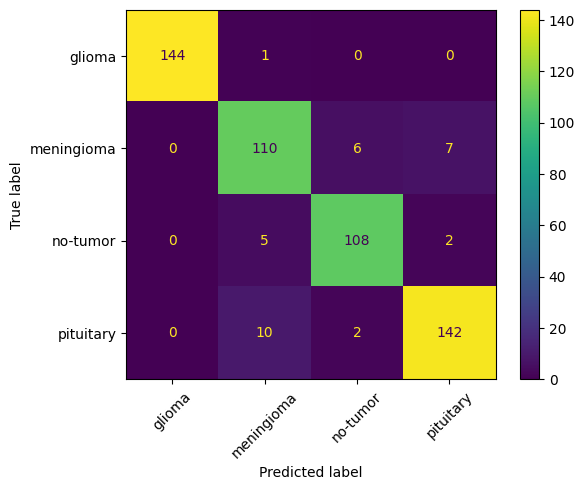

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

test_ds = ds['test'].with_transform(transform)
test_outputs = trainer.predict(test_ds)

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

In [ ]:
from huggingface_hub import login

login(token="your-hf-token")

# Push the model to Hugging Face Hub
model.push_to_hub("alijaanai/vit-finetuned-brain-tumor-classification")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/alijaanai/vit-finetuned-brain-tumor-classification/commit/0082d6e6644685c2abf50d359bb738179d5f8027', commit_message='Upload ViTForImageClassification', commit_description='', oid='0082d6e6644685c2abf50d359bb738179d5f8027', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import HfApi

# Initialize Hugging Face API
api = HfApi()

# Define file paths
file_path = "/content/output/preprocessor_config.json"
repo_id = "alijaanai/vit-finetuned-brain-tumor-classification"  # Your Hugging Face model repo

# Push the preprocessor config file to the repo
api.upload_file(
    path_or_fileobj=file_path,
    path_in_repo="preprocessor_config.json",  # Name under which the file will appear in the repo
    repo_id=repo_id
)


CommitInfo(commit_url='https://huggingface.co/alijaanai/vit-finetuned-brain-tumor-classification/commit/b77c2ef733c98b0f15806aae292d510ea2e968a4', commit_message='Upload preprocessor_config.json with huggingface_hub', commit_description='', oid='b77c2ef733c98b0f15806aae292d510ea2e968a4', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline
from PIL import Image

# Load the image you want to classify
image = Image.open('/content/image.jpg')

# Initialize the pipeline
pipe = pipeline("image-classification", model="alijaanai/vit-finetuned-brain-tumor-classification")

# Perform the classification
result = pipe(image)

# Print the classification result
print(result)


preprocessor_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'glioma', 'score': 0.9999994039535522}, {'label': 'no-tumor', 'score': 0.014034314081072807}, {'label': 'pituitary', 'score': 0.013034678064286709}, {'label': 'meningioma', 'score': 0.007183384615927935}]


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import torch

# Load the image processor and model
processor = AutoImageProcessor.from_pretrained("alijaanai/vit-finetuned-brain-tumor-classification")
model = AutoModelForImageClassification.from_pretrained("alijaanai/vit-finetuned-brain-tumor-classification")

# Load your test image
image = Image.open('/content/image.jpg')

# Preprocess the image using the processor
inputs = processor(images=image, return_tensors="pt")

# Perform inference with the model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get the predicted label
predicted_class_idx = logits.argmax(-1).item()
print(f"Predicted class index: {predicted_class_idx}")


Predicted class index: 0
